<a href="https://colab.research.google.com/github/farshid101/Deep-learning-Practice/blob/main/EfficientNet_v2_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNZIP file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile

with ZipFile("/content/drive/MyDrive/Paper work/SalmonScan.zip",'r') as zipobj:
  zipobj.extractall("/content/SalmonScan")





# Spliting the dataset



```
pip install split-folders
```

YT LINk for help :[link ](https://youtu.be/C6wbr1jJvVs?si=R9SslwqTRy1VAG_R)

Github LINk for help :[link ](https://github.com/bnsreenu/python_for_microscopists/blob/master/221_split_folder_into_train_test_val.py)

In [3]:
pip install split-folders

In [4]:
import splitfolders  # or import split_folders

### Making a function for reuse in future

In [5]:
def split_folders(input_folder ,output_folder,train=0.8,test=0.2 ,seed=42):
  """
  input:
  input_folder ,output_folder

  defult:
  train=0.7,test=0.2 ,val=0.1,seed=42

   Split with a ratio.
   To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
   Train, val, test

  Need install : pip install split-folders
  """

  import splitfolders  # or import split_folders
  splitfolders.ratio(input_folder, output=output_folder,
                   seed=seed, ratio=(train, test ),
                   group_prefix=None) # default values

split_folders("/content/SalmonScan",'SalmonScan split part_1',train=.8,test=.2)

Copying files: 1208 files [00:00, 2172.78 files/s]


# Image Load

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [7]:

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class) # Changed
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


Image shape: (250, 600, 3)


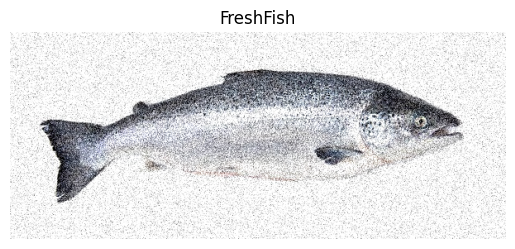

In [8]:
img = view_random_image(target_dir="/content/SalmonScan split part_1/train/",
                        target_class="FreshFish")

Image shape: (250, 600, 3)


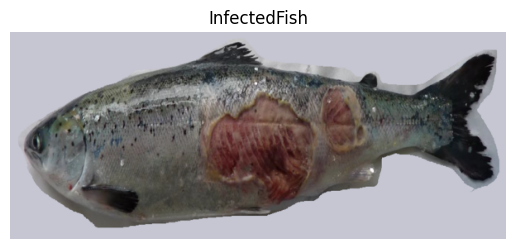

In [9]:
img = view_random_image(target_dir="/content/SalmonScan split part_1/train/",
                        target_class="InfectedFish")

# Making a function to see random image from directory and target class

In [10]:
def random_view(T_target_dir , T_target_class  , Te_target_dir , Te_target_class ):
  plt.figure(figsize=(16,10))
  for i in range(10):
    ax=plt.subplot( 5 ,2 ,i+1 )
    if(i%2==1):
      view_random_image(T_target_dir, T_target_class)
    else:
      view_random_image(Te_target_dir, Te_target_class)

Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)
Image shape: (250, 600, 3)


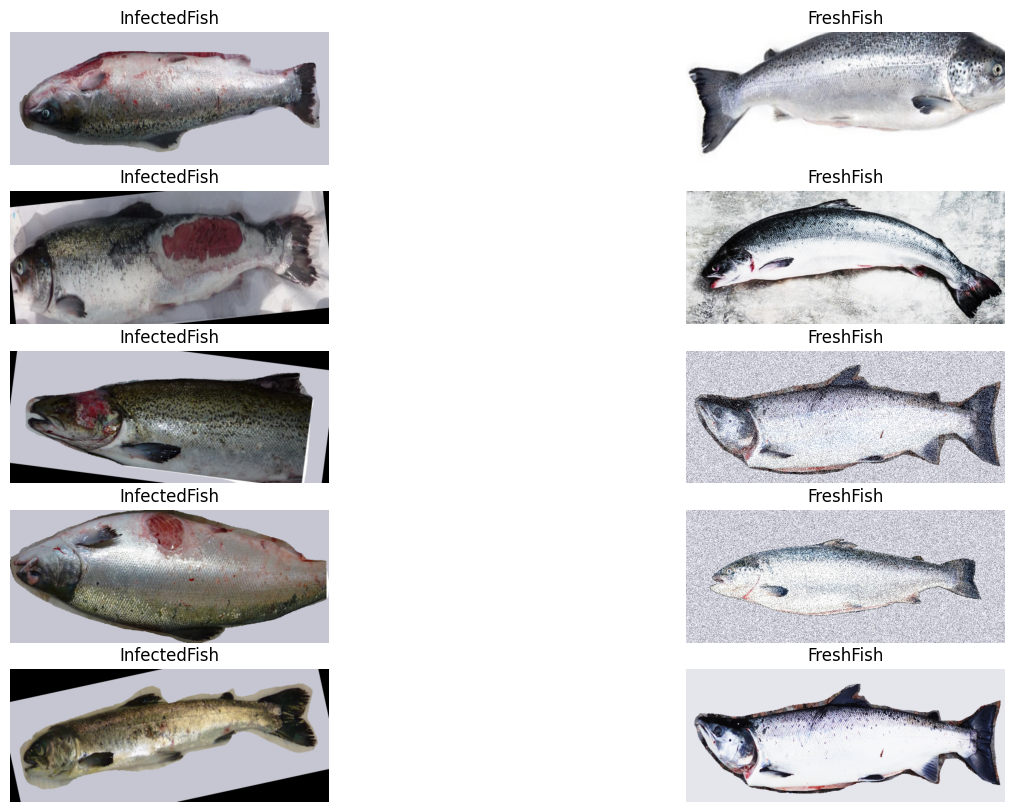

In [11]:
 random_view("/content/SalmonScan split part_1/train/","FreshFish","/content/SalmonScan split part_1/train/", "InfectedFish" )

# Creating data loaders (preparing the data)


In [12]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


IMAGE_SHAPE = (600, 250)
BATCH_SIZE = 32

train_dir = "/content/SalmonScan split part_1/train"
test_dir = "/content/SalmonScan split part_1/val"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
target_size=IMAGE_SHAPE,
batch_size=BATCH_SIZE,
class_mode="binary")

print("Testing images:")

test_data = train_datagen.flow_from_directory(test_dir,
target_size=IMAGE_SHAPE,
batch_size=BATCH_SIZE,
class_mode="binary")

Training images:
Found 965 images belonging to 2 classes.
Testing images:
Found 243 images belonging to 2 classes.


# Setting up callbacks (things to run whilst our model trains)


In [13]:
# Create tensorboard callback (functionized because need to create a new one for each mode
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using TensorFlow Hub

In [14]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

## Model function for tensorflow hub

# **EfficentNet**

In [15]:
efficientnet="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2"

In [16]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer
  ])

  return model

In [17]:

# Create model
efficientnet_model = create_model(efficientnet, num_classes=1)

In [18]:
efficientnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [19]:
efficientnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
efficientnet_model_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=30,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="ImgNet")]) # name of log files


Saving TensorBoard log files to: tensorflow_hub/ImgNet/20231126-062456
Epoch 1/30
31/31 [==============================] - 39s 504ms/step - loss: 0.6634 - accuracy: 0.6642 - val_loss: 0.3983 - val_accuracy: 0.8724
Epoch 2/30
31/31 [==============================] - 11s 346ms/step - loss: 0.3354 - accuracy: 0.8591 - val_loss: 0.3562 - val_accuracy: 0.8807
Epoch 3/30
31/31 [==============================] - 12s 384ms/step - loss: 0.2830 - accuracy: 0.8902 - val_loss: 0.3230 - val_accuracy: 0.8930
Epoch 4/30
31/31 [==============================] - 12s 387ms/step - loss: 0.2465 - accuracy: 0.9078 - val_loss: 0.3114 - val_accuracy: 0.8765
Epoch 5/30
31/31 [==============================] - 11s 356ms/step - loss: 0.2315 - accuracy: 0.9140 - val_loss: 0.2931 - val_accuracy: 0.8971
Epoch 6/30
31/31 [==============================] - 12s 375ms/step - loss: 0.2124 - accuracy: 0.9264 - val_loss: 0.2861 - val_accuracy: 0.9053
Epoch 7/30
31/31 [==============================] - 12s 386ms/step - lo

# Making a comparing history function

In [20]:
import matplotlib.pyplot as plt

def plot_compare_history(histories):
    """
    Plots separate loss curves for training and validation metrics for multiple histories.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each history

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    for i, history in enumerate(histories):
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']

        epochs = range(len(history.history['loss']))

        # Plot loss
        ax1.plot(epochs, loss, label=f'Training Loss {i+1}', color=colors[i])
        ax1.plot(epochs, val_loss, label=f'Validation Loss {i+1}', linestyle='--', color=colors[i])
        ax1.set_title('Loss')
        ax1.set_xlabel('Epochs')
        ax1.legend()

        # Plot accuracy
        ax2.plot(epochs, accuracy, label=f'Training Accuracy {i+1}', color=colors[i])
        ax2.plot(epochs, val_accuracy, label=f'Validation Accuracy {i+1}', linestyle='--', color=colors[i])
        ax2.set_title('Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


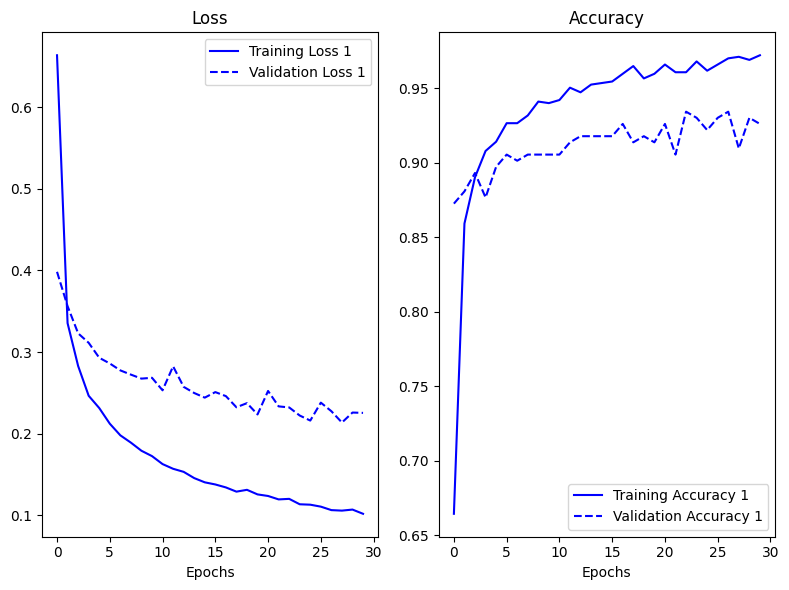

In [21]:
histories = [ efficientnet_model_history]
plot_compare_history(histories)

# Making model trainable

In [34]:

def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 1,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = base_model(inputs, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="sigmoid", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [35]:
# Create an instance of model_2 with our new function
model_2 = create_base_model()


# Layers in loaded model
model_2.layers

In [36]:

# Access the base_model layers of model_2
model_2_base_model = model_2.layers[1]
print(model_2_base_model.name)


# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables))

efficientnetv2-b0
0


# checking layers

In [37]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

# making last  2 layer trainable

In [68]:

# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 2
for layer in model_2_base_model.layers[:-2]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

# Check which layers are tuneable (trainable)

In [69]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [70]:
print(len(model_2.trainable_variables))

4


In [71]:

# Fit the model
model_2_base_model_history_trainable = model_2.fit(train_data_10_percent,
                                  epochs=30,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="ImgNet")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/ImgNet/20231126-074408
Epoch 1/30
31/31 [==============================] - 20s 419ms/step - loss: 0.5962 - accuracy: 0.6642 - val_loss: 0.6241 - val_accuracy: 0.6420
Epoch 2/30
31/31 [==============================] - 11s 366ms/step - loss: 0.5883 - accuracy: 0.6684 - val_loss: 0.6241 - val_accuracy: 0.6420
Epoch 3/30
31/31 [==============================] - 11s 361ms/step - loss: 0.5890 - accuracy: 0.6674 - val_loss: 0.6250 - val_accuracy: 0.6461
Epoch 4/30
31/31 [==============================] - 14s 439ms/step - loss: 0.5879 - accuracy: 0.6715 - val_loss: 0.6240 - val_accuracy: 0.6420
Epoch 5/30
31/31 [==============================] - 11s 368ms/step - loss: 0.5884 - accuracy: 0.6674 - val_loss: 0.6254 - val_accuracy: 0.6461
Epoch 6/30
31/31 [==============================] - 11s 347ms/step - loss: 0.5882 - accuracy: 0.6663 - val_loss: 0.6253 - val_accuracy: 0.6461
Epoch 7/30
31/31 [==============================] - 11s 370ms/step - lo

# Comparing history of trainable and not trainable

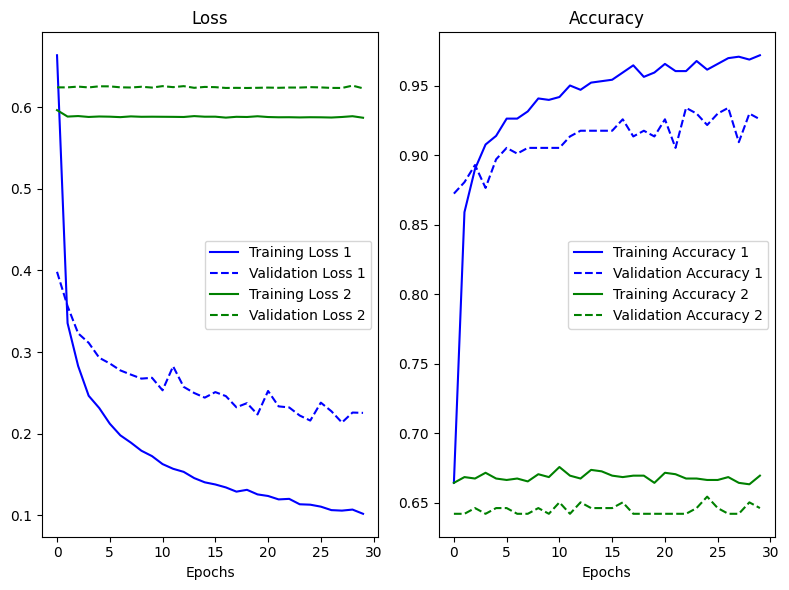

In [73]:
histories = [ efficientnet_model_history  , model_2_base_model_history_trainable ]
plot_compare_history(histories)

# Improving Model with Data augmentation

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

### Here Shuffle is false

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

### Get data batch samples

In [ ]:

images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

### Show original image and augmented image

In [ ]:

# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance

plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

### Fit the model in resnet_model

In [ ]:
# Fit the model
resnet_history_Augmented = resnet_model.fit(train_data_augmented,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2_Augmented")]) # name of log files


# History Compare of  resnet_history and  resnet_history_Augmented

In [ ]:
histories = [ resnet_history ,resnet_history_Augmented]
plot_compare_history(histories)

# Prediction

## Load and prepared image function

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


## Model and file show function for prediction

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);


In [ ]:
class_names=["FreshFish", "InfectedFish"]

image = input("image copy path :")

pred_and_plot(resnet_model, image, class_names)